In [34]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=1000,skip_top=3 ) # load dataset and split it between training and testing

word_index = tf.keras.datasets.imdb.get_word_index() # word index = (word : num of appearances)

index2word = dict((i, word) for (word, i) in word_index.items())

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train]) # create datasets in numpy array format
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

In [35]:
vacabulary = list()
for text in x_train:
  tokens = text.split()
  vacabulary.extend(tokens)

vocabulary = set(vacabulary)
print(len(vocabulary))

997


In [36]:
dictonary  = dict()
for world in vacabulary :
  dictonary[world] = 0

print(len(dictonary))

997


In [37]:
dictonary  = dict()
for world in vacabulary :
  if world in dictonary:
    dictonary.update({world: dictonary[world] + 1})
  else:
    dictonary[world] = 0

print(len(dictonary))

997


In [42]:
from collections import OrderedDict
#oti prints einai se sxolia einai apla gia na elexoume oti egine sosta i aferesi ton k spanioteron lexeon me xrisi dictonary

sorted_dict = dict(sorted(dictonary.items(), key=lambda item: item[1]),reverse = True)
counter = 0
k = 5
"""for x in sorted_dict:
  print(x,sorted_dict[x])
"""
for x in list(sorted_dict):
  print(x,sorted_dict.pop(x,None))
  counter =  counter + 1

  if counter == 5:
    break
print()
"""for x in sorted_dict:
  print(x,sorted_dict[x])"""

cop 600
co 603
portrayed 605
era 605
fighting 606



'for x in sorted_dict:\n  print(x,sorted_dict[x])'

In [43]:
neoVocabulary = list()
for x in sorted_dict:
  neoVocabulary.append(x)

"""for x in neoVocabulary:
  print(x)"""

print(len(neoVocabulary))
print(len(sorted_dict))


993
993


In [44]:
from tqdm import tqdm

x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in neoVocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in neoVocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)

100%|██████████| 25000/25000 [00:52<00:00, 472.88it/s]


In [45]:
class BNB:
    def __init__(self,X,y,a=1):
        self.a = a # alpha yperparametros
        self.y_count_each = np.unique(y, return_counts=True)[1] # 12500 pos and 12500 negative reviews
        self.categories = 2 # postivie and negative ( 0 or 1)
        self.num_of_words = X.shape[1] # number of words in the vocabulary
        

        return


    def fit(self,X,y):
        
        # propability of P(x==1) and P(x==0)
        # aka propability of being 1 and 0 , since we have fifty fifty 12500 pos
        # and 12500 neg its 0.5 and 0.5 for each one

        self.prop_of_each_class = self.y_count_each / self.y_count_each.sum()
        self.logged_prop_of_each_class = np.expand_dims(np.log(self.prop_of_each_class),axis = 1)

        # self.prop_of_each_class = [12500,12500]
        # so P(1) == P(0) == 0.5



        # propability of P(x|y) , the propability of x given y

        prob_ofX_knowingY = np.zeros([self.categories, self.num_of_words])
        # initializing numpy array with zeros
        # [[0.0.0.0.0 ... 0.0.0.]
        #  [0.0.0.0.0 ... 0.0.0.]   {     2 x (number of words)    }


        # ----------------------------------------------------------------------



        X_filtered = X[y==0,:] # take the rows where class is 0 


        number_of_zeros = np.zeros(self.num_of_words) # sum of 1s and 0s in each collumn
        counter = 0                                                          
        for i in range(0,self.num_of_words):
            counter = 0
            for j in range(0,X_filtered.shape[0]):
                # if (X_filtered[j,i] == 0):
                counter+=X_filtered[j,i]
            number_of_zeros[i] = counter



        n1 = (number_of_zeros + self.a)


        prob_ofX_knowingY[0,:] = n1 / (12500+self.a*2)

        

        # now same thing for class 1

        X_filtered = X[y==1,:] # take the rows where class is 0

        number_of_zeros2 = np.zeros(self.num_of_words) # sum of 1s and 0s in each collumn again 
        counter = 0                                                        
        for i in range(0,self.num_of_words):
            counter = 0
            for j in range(0,X_filtered.shape[0]):
                # if (X_filtered[j,i] == 0):
                counter+=X_filtered[j,i]
            number_of_zeros2[i] = counter
        

        n2 = (number_of_zeros2 + self.a)
        prob_ofX_knowingY[1,:] = n2 / (12500+self.a*2)
     

        
        # ----------------------------------------------------------------------


       # using log() to the entire array of propabilities

        self.logged_positive = np.log(prob_ofX_knowingY) # P(Xn|y=0)
        self.logged_negative = np.log(1 - prob_ofX_knowingY) # P(Xn|y=1)


    def predict(self, X):

        # log P(y|x) is proportional to log P(x|y) + log P(y)
        # each n x 1 column vector is contains a value proportional to P(y|x)
        # for every possible class of y
        
        self.logged_positive2 = np.dot(self.logged_positive,X.T)
        self.logged_negative2 = np.dot(self.logged_negative,X.T)

        
        log_likelihoods = self.logged_positive2 + self.logged_negative2 # n x m matrix , join arrays


        log_joint_likelihoods = log_likelihoods + self.logged_prop_of_each_class 




        preds = np.argmax(log_joint_likelihoods, axis = 0) # 1 x m matrix
        
        #preds = np.array(preds).squeez(e) # m-dimensional vector
        return preds

In [46]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

clf = BNB(x_train_binary,y_train,a=0.001)
clf.fit(x_train_binary,y_train)
predictions1 = clf.predict(x_test_binary)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions1))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84     12500
           1       0.86      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



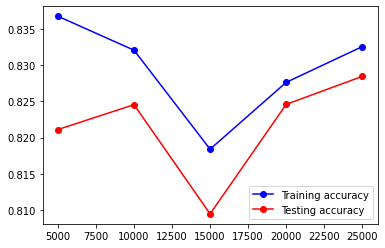

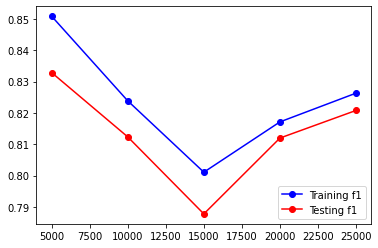

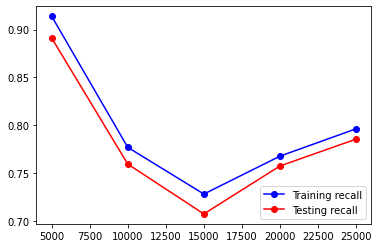

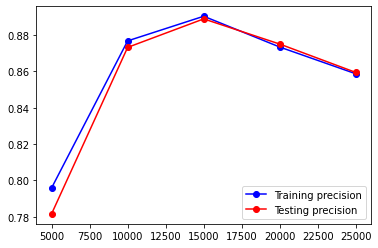

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

def custom_learning_curve(type,x_train, y_train, x_test, y_test,n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  curr_y = y_splits[0]
  bnb = BNB(curr_x, curr_y,a=0.001)
  bnb.fit(curr_x, curr_y)

  if (type == 'accuracy'):
    train_accuracies.append(accuracy_score(curr_y,bnb.predict(curr_x)))
    test_accuracies.append(accuracy_score(y_test, bnb.predict(x_test)))
  elif (type == 'f1'):
    train_accuracies.append(f1_score(curr_y,bnb.predict(curr_x)))
    test_accuracies.append(f1_score(y_test, bnb.predict(x_test)))
  elif (type == "recall"):
    train_accuracies.append(recall_score(curr_y,bnb.predict(curr_x)))
    test_accuracies.append(recall_score(y_test, bnb.predict(x_test)))
  else:
    train_accuracies.append(precision_score(curr_y,bnb.predict(curr_x)))
    test_accuracies.append(precision_score(y_test, bnb.predict(x_test)))
    



  for i in range(1, len(x_splits)):
    bnb = BNB(curr_x, curr_y,a=0.001)
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    bnb.fit(curr_x, curr_y)
    if (type == 'accuracy'):
      train_accuracies.append(accuracy_score(curr_y,bnb.predict(curr_x)))
      test_accuracies.append(accuracy_score(y_test, bnb.predict(x_test)))
    elif (type == 'f1'):
      train_accuracies.append(f1_score(curr_y,bnb.predict(curr_x)))
      test_accuracies.append(f1_score(y_test, bnb.predict(x_test)))
    elif (type == "recall"):
      train_accuracies.append(recall_score(curr_y,bnb.predict(curr_x)))
      test_accuracies.append(recall_score(y_test, bnb.predict(x_test)))
    else:
      train_accuracies.append(precision_score(curr_y,bnb.predict(curr_x)))
      test_accuracies.append(precision_score(y_test, bnb.predict(x_test)))


  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training"+" "+type)

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing"+" "+type)
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve('accuracy',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

custom_learning_curve('f1',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

custom_learning_curve('recall',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

custom_learning_curve('precision',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

In [49]:
# MEROS B

In [50]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report


nb = BernoulliNB()
nb.fit(x_train_binary, y_train)


print(classification_report(y_test, nb.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81     12500
           1       0.80      0.84      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.82      0.81      0.81     25000



In [51]:
def custom_learning_curve2(type,x_train, y_train, x_test, y_test,n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  curr_y = y_splits[0]
  bnb2 = BernoulliNB()
  bnb2.fit(curr_x, curr_y)

  if (type == 'accuracy'):
    train_accuracies.append(accuracy_score(curr_y,bnb2.predict(curr_x)))
    test_accuracies.append(accuracy_score(y_test, bnb2.predict(x_test)))
  elif (type == 'f1'):
    train_accuracies.append(f1_score(curr_y,bnb2.predict(curr_x)))
    test_accuracies.append(f1_score(y_test, bnb2.predict(x_test)))
  elif (type == "recall"):
    train_accuracies.append(recall_score(curr_y,bnb2.predict(curr_x)))
    test_accuracies.append(recall_score(y_test, bnb2.predict(x_test)))
  else:
    train_accuracies.append(precision_score(curr_y,bnb2.predict(curr_x)))
    test_accuracies.append(precision_score(y_test, bnb2.predict(x_test)))
    



  for i in range(1, len(x_splits)):
    bnb2 = BernoulliNB()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    bnb2.fit(curr_x, curr_y)
    if (type == 'accuracy'):
      train_accuracies.append(accuracy_score(curr_y,bnb2.predict(curr_x)))
      test_accuracies.append(accuracy_score(y_test, bnb2.predict(x_test)))
    elif (type == 'f1'):
      train_accuracies.append(f1_score(curr_y,bnb2.predict(curr_x)))
      test_accuracies.append(f1_score(y_test, bnb2.predict(x_test)))
    elif (type == "recall"):
      train_accuracies.append(recall_score(curr_y,bnb2.predict(curr_x)))
      test_accuracies.append(recall_score(y_test, bnb2.predict(x_test)))
    else:
      train_accuracies.append(precision_score(curr_y,bnb2.predict(curr_x)))
      test_accuracies.append(precision_score(y_test, bnb2.predict(x_test)))


  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training"+" "+type)

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing"+" "+type)
  plt.legend(loc="lower right")
  plt.show()

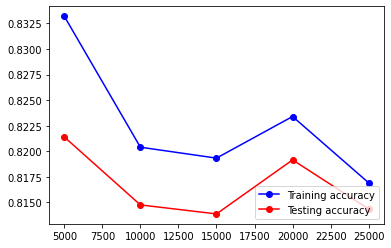

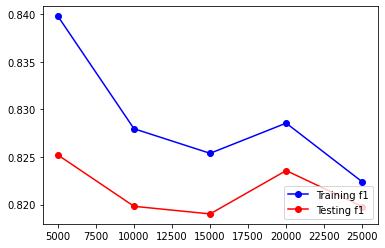

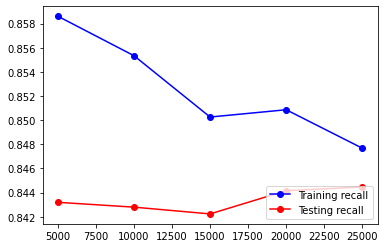

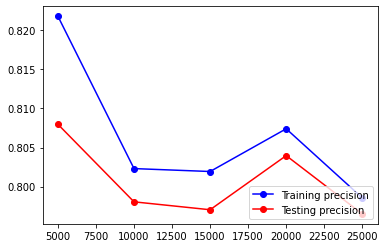

In [52]:
custom_learning_curve2('accuracy',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

custom_learning_curve2('f1',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

custom_learning_curve2('recall',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

custom_learning_curve2('precision',x_train=x_train_binary, y_train=y_train,x_test=x_test_binary,
                      y_test=y_test, n_splits=5)